# Flatten microwave transmission with the ZVL6 and MWSMF100A

Dinesh Pinto (d.pinto@fkf.mpg.de)

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import mw_transmission_optimization as mto
from scipy.interpolate import interp1d

In [2]:
FOLDER_PATH = os.path.join("Z:", "Data", "20210816_RTStageTesting_MW_MembraneSample")

In [3]:
FILE_PATH = os.path.join(FOLDER_PATH, "20211007_NetworkAnalysisAmplifier.csv")

# Get current transmission function
Invert it and interpolate, generate new data set with resolution of the SMF100A (within the memory constraints)

In [4]:
zvl = mto.RohdeSchwarzZVL('TCPIP::192.168.0.18::INSTR')
frequency, power = zvl.get_trace(points=4000)
corrected_power = mto.get_corrected_power(power)

mto.write_to_csv(frequency, power, corrected_power, FILE_PATH)

Success! Connected to Rohde&Schwarz,ZVL-6,1303.6509K06/101534,3.32


In [5]:
frequency, power, corrected_power = mto.read_from_csv(FILE_PATH)

In [6]:
FREQUENCY_PRECISION = 500e3

f = interp1d(frequency, corrected_power)
frequency_interp = np.arange(1e9, 6e9, FREQUENCY_PRECISION)
corrected_power_interp = f(frequency_interp)

In [7]:
len(corrected_power_interp)

10000

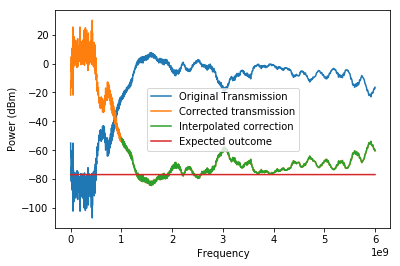

In [8]:
fig, ax = plt.subplots()

ax.plot(frequency, power, label="Original Transmission")
ax.plot(frequency, corrected_power, label="Corrected transmission")
ax.plot(frequency_interp, corrected_power_interp, label="Interpolated correction")
ax.plot(frequency, power + corrected_power, label="Expected outcome")
ax.set(xlabel="Frequency", ylabel="Power (dBm)")
ax.legend()

# Send the interpolated values to the MW source
With the precision defined by the memory limit of the MW source (~500 kHz for 1 - 6 GHz range)

In [9]:
frequency_string, corrected_power_string = mto.generate_f_p_strings(frequency_interp, corrected_power_interp)

In [10]:
smf = mto.MWSMF100A('TCPIP0::192.168.0.6::inst0::INSTR')

In [11]:
smf.create_user_correction_file(name="odmr")
smf.write_string_to_device(frequency_string, corrected_power_string)
print(smf.check_number_of_points())

('10000\n', '10000\n')


In [12]:
smf.load_user_correction_and_turn_on(name="odmr")

# Test the result of the correction  

On SMF100A
- (1 GHz, 6 GHz, 1 MHz)
- Dwell time = 200 ms

In [ ]:
FILE_PATH_AFTER = os.path.join(FOLDER_PATH, "20210818_NetworkAnalysisAmplifier_after_correction.dat")

In [ ]:
output_frequency, output_power = mto.read_from_dat(FILE_PATH_AFTER)

In [ ]:
fig, ax = plt.subplots()

ax.plot(frequency, power, linewidth=0.7, label="Original transmission")
#ax.plot(frequency, corrected_power, linewidth=0.5, label="Inverted transmission")
ax.plot(frequency, power + corrected_power, linewidth=0.7, label="Expected outcome")
ax.plot(output_frequency, output_power, linewidth=0.7, label="Optimized transmission")
ax.set(xlabel="Frequency", ylabel="Power (dBm)")
ax.legend()
#ax.set_xlim([2.6e9, 3.2e9])
fig.savefig(os.path.join(FOLDER_PATH, "20210818_NetworkAnalysisAmplifier_after_correction_optimized.png"), dpi=600, bbox_inches="tight")